# LeNet-5 Image Predictor

This notebook loads a trained LeNet-5 model and predicts custom images.
No training required - just load the saved model and predict!

## 1. Import Required Libraries

In [9]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration - Set Your Paths

Update these paths to match your setup:
- `BASE_PATH`: Root folder for your dataset
- `RESULTS_PATH`: Folder where model weights are saved
- `checkpoint_filepath`: Path to the saved model weights file

In [10]:
# Configuration - Set your paths here
BASE_PATH = '/home/ubuntu/Desktop/AIML project/AlphaNum'
TRAIN_PATH = os.path.join(BASE_PATH, "train")
RESULTS_PATH = '/home/ubuntu/Desktop/AIML project/results/LeNet-5'

# IMPORTANT: Use the improved model (better accuracy!)
checkpoint_filepath = os.path.join(RESULTS_PATH, 'best_model_quick_improved.weights.h5')

# If improved model doesn't work, try baseline:
# checkpoint_filepath = os.path.join(RESULTS_PATH, 'best_model.weights.h5')

# Image specifications (must match training setup)
IMG_HEIGHT = 24
IMG_WIDTH = 24
IMG_CHANNELS = 1  # Grayscale

print(f"Model weights path: {checkpoint_filepath}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")

# Verify paths exist
if os.path.exists(checkpoint_filepath):
    print("✓ Model weights file found!")
else:
    print(" Model weights file not found!")
    print("\nAvailable models:")
    if os.path.exists(RESULTS_PATH):
        for f in os.listdir(RESULTS_PATH):
            if f.endswith('.h5'):
                print(f"  - {f}")

if os.path.exists(TRAIN_PATH):
    print("✓ Training path found!")
else:
    print(" Training path not found!")

Model weights path: /home/ubuntu/Desktop/AIML project/results/LeNet-5/best_model_quick_improved.weights.h5
Image size: 24x24x1
✓ Model weights file found!
✓ Training path found!


## 3. Load Class Names

In [11]:
# Get class names from training folder
class_names = sorted([d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))])
num_classes = len(class_names)

print(f"✓ Found {num_classes} classes")
print(f"\nFirst 10 classes: {class_names[:10]}")
print(f"Last 10 classes: {class_names[-10:]}")

# Show character mapping for ASCII-based classes
print("\n Character Mapping (first 10):")
for i, cls in enumerate(class_names[:10]):
    if cls.isdigit():
        ascii_val = int(cls)
        char = chr(ascii_val) if 32 <= ascii_val <= 126 else cls
        print(f"  Class {cls} → '{char}'")

✓ Found 53 classes

First 10 classes: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']
Last 10 classes: ['85', '86', '87', '88', '89', '90', '97', '98', '99', '999']

 Character Mapping (first 10):
  Class 100 → 'd'
  Class 101 → 'e'
  Class 102 → 'f'
  Class 103 → 'g'
  Class 104 → 'h'
  Class 105 → 'i'
  Class 106 → 'j'
  Class 107 → 'k'
  Class 108 → 'l'
  Class 109 → 'm'


## 4. Define Model Architecture

This function creates the LeNet-5 model architecture with different configurations.
It will try multiple configurations to match the saved weights.

In [12]:
def create_lenet5_variable(d1=120, d2=84):
    """
    Create LeNet-5 model with variable dense layer sizes (NO dropout, NO regularization)
    This is for the BASELINE model.
    
    Args:
        d1: Units in first dense layer (default: 120)
        d2: Units in second dense layer (default: 84)
    """
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(d1, activation='relu'),
        Dense(d2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_improved_model():
    """
    Create IMPROVED model with BatchNorm and dropout
    This matches the improved model architecture with (128, 128).
    """
    from tensorflow.keras.layers import BatchNormalization, Dropout
    from tensorflow.keras.regularizers import l2
    
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', kernel_regularizer=l2(1e-4),
               input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(1e-4)),
        MaxPooling2D((2, 2)),
        Flatten(),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("✓ Model architecture functions defined")
print("  - create_lenet5_variable(d1, d2) - Variable LeNet-5")
print("  - create_improved_model() - Improved with BatchNorm (128, 128)")

✓ Model architecture functions defined
  - create_lenet5_variable(d1, d2) - Variable LeNet-5
  - create_improved_model() - Improved with BatchNorm (128, 128)


## 5. Load Trained Model Weights

Try different model configurations to find the one that matches the saved weights.

In [13]:
# Auto-detect and load the correct model architecture
print("Attempting to load model weights...\n")
print(f"Loading from: {checkpoint_filepath}\n")

model = None

# Determine which model to use based on filename
if 'quick_improved' in checkpoint_filepath:
    print("Detected IMPROVED model weights file")
    model = create_improved_model()
    try:
        model.load_weights(checkpoint_filepath)
        print("✓ Successfully loaded IMPROVED model (128, 128 with BatchNorm)")
    except Exception as e:
        print(f" Failed: {str(e)[:120]}")
        model = None
else:
    print("Detected BASELINE model weights file")
    print("Trying different configurations...")
    
    # Try different dense layer configurations
    configs = [
        (120, 84),   # Standard LeNet-5
        (224, 84),   # Variant 1
        (120, 120),  # Variant 2
        (128, 128),  # Variant 3
        (256, 128),  # Variant 4
    ]
    
    for d1, d2 in configs:
        try:
            test_model = create_lenet5_variable(d1, d2)
            test_model.load_weights(checkpoint_filepath)
            model = test_model
            print(f"✓ Successfully loaded BASELINE model ({d1}, {d2})")
            break
        except:
            print(f"✗ Config ({d1}, {d2}) doesn't match")
            continue

if model is None:
    print("\n Could not load model with any configuration!")
    print("The weights file may be corrupted or from a different architecture.")
else:
    print(f"\n✓ Model ready for predictions!")
    print(f"✓ Total parameters: {model.count_params():,}")
    print(f"\n✓ You can now use predict_image_with_confidence() to make predictions!")

Attempting to load model weights...

Loading from: /home/ubuntu/Desktop/AIML project/results/LeNet-5/best_model_quick_improved.weights.h5

Detected IMPROVED model weights file
✓ Successfully loaded IMPROVED model (128, 128 with BatchNorm)

✓ Model ready for predictions!
✓ Total parameters: 45,569

✓ You can now use predict_image_with_confidence() to make predictions!


/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Image Preprocessing Function

In [14]:
def load_and_preprocess_image(image_path):
    """
    Load and preprocess image for prediction.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        Preprocessed image array ready for prediction
    """
    # Load image in grayscale and resize to model input size
    img = tf.keras.utils.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    # Convert to array and normalize to [0, 1]
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    
    # Add batch dimension
    img_input = tf.expand_dims(img_array, 0)
    
    return img_array, img_input

print("✓ Image preprocessing function defined")

✓ Image preprocessing function defined


## 7. Prediction Function with Visualization

In [15]:
def predict_image_with_confidence(image_path, top_k=5):
    """
    Predict image class and show confidence with visualization.
    
    Args:
        image_path: Path to the image to predict
        top_k: Number of top predictions to show (default: 5)
    """
    # Check if image exists
    if not os.path.exists(image_path):
        print(f" Image not found: {image_path}")
        return
    
    # Load and preprocess image
    img_array, img_input = load_and_preprocess_image(image_path)
    
    # Get predictions
    predictions = model.predict(img_input, verbose=0)
    confidence = np.max(predictions[0]) * 100
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    
    # Convert to character if it's an ASCII code
    if predicted_class.isdigit():
        ascii_val = int(predicted_class)
        predicted_char = chr(ascii_val) if 32 <= ascii_val <= 126 else predicted_class
    else:
        predicted_char = predicted_class
    
    # Get top K predictions
    top_k_idx = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_conf = predictions[0][top_k_idx] * 100
    top_k_labels = [class_names[i] for i in top_k_idx]
    
    # Convert top K labels to characters
    top_k_chars = []
    for label in top_k_labels:
        if label.isdigit():
            ascii_val = int(label)
            top_k_chars.append(chr(ascii_val) if 32 <= ascii_val <= 126 else label)
        else:
            top_k_chars.append(label)
    
    # Visualization
    plt.figure(figsize=(14, 5))
    
    # 1. Show input image
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title(f'Input Image\n{os.path.basename(image_path)}', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 2. Show preprocessed image
    plt.subplot(1, 3, 2)
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title(f'Preprocessed\n{IMG_HEIGHT}x{IMG_WIDTH} Grayscale', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 3. Show top K predictions as horizontal bar chart
    plt.subplot(1, 3, 3)
    colors = ['green' if i == 0 else 'lightblue' for i in range(top_k)]
    y_pos = np.arange(top_k)
    plt.barh(y_pos, top_k_conf, color=colors, alpha=0.8)
    plt.yticks(y_pos, [f"{char} ({label})" for char, label in zip(top_k_chars, top_k_labels)], fontsize=10)
    plt.xlabel('Confidence (%)', fontsize=11)
    plt.title(f'Top {top_k} Predictions', fontsize=12, fontweight='bold')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # Highest confidence at top
    
    # Add confidence values on bars
    for i, conf in enumerate(top_k_conf):
        plt.text(conf + 1, i, f'{conf:.2f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction summary
    print("\n" + "="*70)
    print(" PREDICTION RESULT")
    print("="*70)
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Character: '{predicted_char}'")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    print("="*70)
    
    print(f"\n Top {top_k} Predictions:")
    for i, (char, label, conf) in enumerate(zip(top_k_chars, top_k_labels, top_k_conf), 1):
        print(f"  {i}. '{char}' (class: {label}) - {conf:.2f}%")
    print("="*70)

print("✓ Prediction function defined")

✓ Prediction function defined


## 8. Predict Custom Image

**Change the `custom_image_path` below to your image path and run the cell!**

This will:
- Load your image
- Preprocess it (resize to 24x24 grayscale)
- Predict the character
- Show confidence scores for top 5 predictions

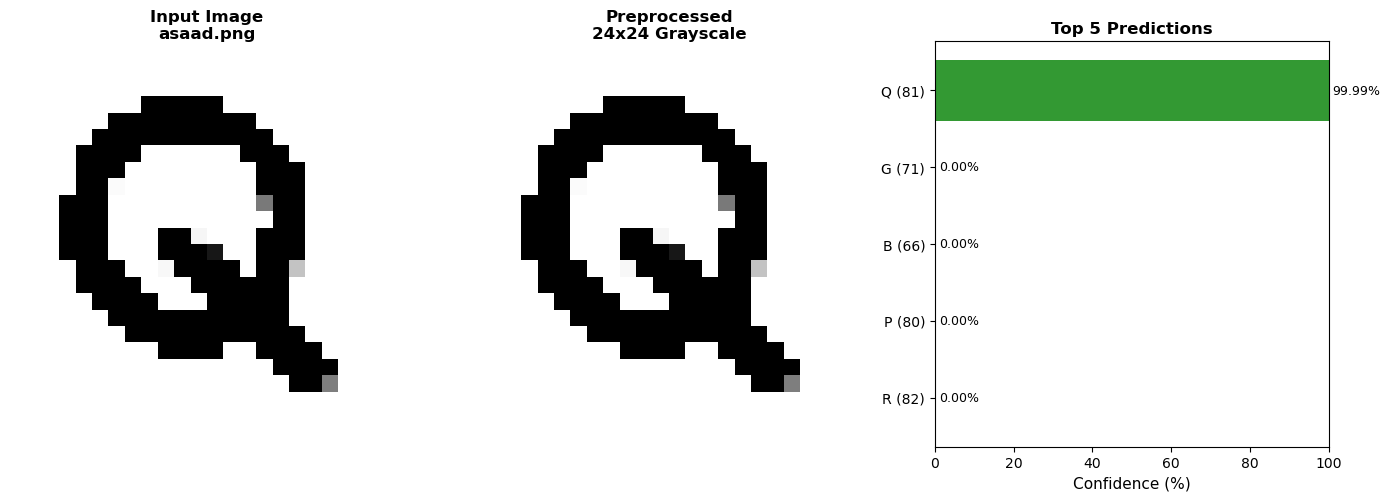


 PREDICTION RESULT
Image: asaad.png
Predicted Character: 'Q'
Predicted Class: 81
Confidence: 99.99%

 Top 5 Predictions:
  1. 'Q' (class: 81) - 99.99%
  2. 'G' (class: 71) - 0.00%
  3. 'B' (class: 66) - 0.00%
  4. 'P' (class: 80) - 0.00%
  5. 'R' (class: 82) - 0.00%


In [16]:
# CHANGE THIS PATH TO YOUR IMAGE
custom_image_path = '/home/ubuntu/Pictures/asaad.png'

# Run prediction
predict_image_with_confidence(custom_image_path, top_k=5)